In [56]:
from typing_extensions import TypedDict, Literal
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o")

dumb_llm = init_chat_model("openai:gpt-3.5-turbo")
average_llm = init_chat_model("openai:gpt-4o")
smart_llm = init_chat_model("openai:gpt-5-2025-08-07")

In [57]:
class State(TypedDict):

    question: str
    difficulty: str
    answer: str
    model_used: str


class DifficultyResponse(BaseModel):

    difficulty_level: Literal["easy", "medium", "hard"]

In [ ]:
def dumb_node(state: State):
    response = dumb_llm.invoke(state["question"])
    return {"answer": response.content, "model_used": "gpt-3.5-turbo"}


def average_node(state: State):
    response = average_llm.invoke(state["question"])
    return {"answer": response.content, "model_used": "gpt-4o"}


def smart_node(state: State):
    response = smart_llm.invoke(state["question"])
    return {"answer": response.content, "model_used": "gpt-5-2025-08-07"}


def assess_difficulty(state: State):
    strutured_llm = llm.with_structured_output(DifficultyResponse)

    response = strutured_llm.invoke(
        f"""
        Assess the difficulty of the this question:
        Question: {state["question"]}
        
        -EASY: Simple facts, basic definitions, yes/no answers
        -MEDIUM: Requires explanation, comparison, analysis
        -HARD: Complex reasoning, multiple steps, deep expertise.
        """
    )

    difficulty_level = response.difficulty_level

    if difficulty_level == "easy":
        goto = "dumb_node"
    elif difficulty_level == "medium":
        goto = "average_node"
    elif difficulty_level == "hard":
        goto = "smart_node"

    return Command(goto=goto, update={"difficulty": difficulty_level})

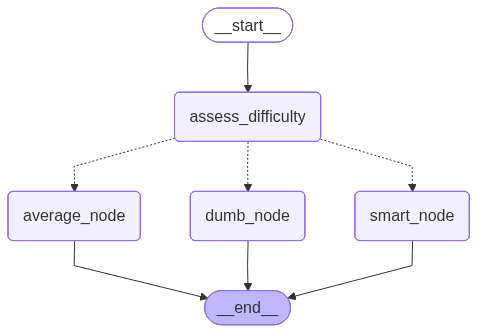

In [59]:
graph_builder = StateGraph(State)

graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)
graph_builder.add_node(
    "assess_difficulty",
    assess_difficulty,
    destinations=("dumb_node", "average_node", "smart_node"),
)

graph_builder.add_edge(START, "assess_difficulty")
graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("average_node", END)
graph_builder.add_edge("smart_node", END)

graph = graph_builder.compile()

graph

In [60]:
graph.invoke({"question": "Investment potential of Uranium in 2026"})

{'question': 'Investment potential of Uranium in 2026',
 'difficulty': 'hard',
 'answer': 'Here’s a concise, investor-focused view of uranium’s setup into 2026.\n\nExecutive take\n- Thesis: Structural deficits built over the last decade, policy tailwinds for nuclear, and tight conversion/enrichment capacity keep the cycle intact into 2026. Expect elevated volatility but supportive fundamentals versus the long-run incentive price needed to bring new supply online.\n- Who benefits most in 2026: Low-cost producers and near-term restarts; fuel-cycle (conversion/enrichment) beneficiaries; diversified uranium ETFs. High-cost developers remain most sensitive to price pullbacks and financing conditions.\n\nDemand drivers into 2026\n- Reactor fleet growth and life extensions:\n  - China continues the fastest new-build cadence; Middle East and India add units; Japanese restarts continue; multiple Western lifetime extensions (U.S., France) support baseline demand.\n- Policy and security-of-supply